In [98]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import pointbiserialr


datapath = Path.cwd().parent / "data" / "sunshines-v4.csv"
df = pd.read_csv(datapath)

#
# infer features
#


def get_latest_totalcomp(row):
    years = ["2023", "2022", "2021", "2020"]
    for year in years:
        salary_col = f"salary_{year}"
        benefits_col = f"benefits_{year}"
        if salary_col in row.index and benefits_col in row.index:  # fall back to previous year if current year is missing
            if pd.notna(row[salary_col]) and pd.notna(row[benefits_col]):  # check if both present
                return row[salary_col] + row[benefits_col]  # get total comp
    print(f"warning: {row['name']}")
    return pd.NA


def get_latest_role(row):
    years = ["2023", "2022", "2021", "2020"]
    for year in years:
        role_col = f"role_{year}"
        if role_col in row.index:  # fall back to previous year if current year is missing
            if pd.notna(row[role_col]):  # check if present
                return row[role_col]
    print(f"warning: {row['name']}")
    return pd.NA


def get_latest_role_cluster(row):
    years = ["2023", "2022", "2021", "2020"]
    for year in years:
        role_col = f"role_cluster_{year}"
        if role_col in row.index:  # fall back to previous year if current year is missing
            if pd.notna(row[role_col]):  # check if present
                return row[role_col]
    print(f"warning: {row['name']}")
    return pd.NA


df["latest_totalcomp"] = df.apply(get_latest_totalcomp, axis=1)
df["latest_role"] = df.apply(get_latest_role, axis=1)
df["latest_role_cluster"] = df.apply(get_latest_role_cluster, axis=1)
df["perf_combined"] = df["paper_count"] + df["citation_count"] + df["h_index"]
for year in range(2020, 2024):
    df[f"totalcomp_{year}"] = df[f"salary_{year}"] + df[f"benefits_{year}"]


print(df.dtypes)
df.head()

name                    object
sex                     object
paper_count              int64
citation_count           int64
h_index                  int64
role_2020               object
role_cluster_2020      float64
salary_2020            float64
benefits_2020          float64
role_2021               object
role_cluster_2021      float64
salary_2021            float64
benefits_2021          float64
role_2022               object
role_cluster_2022      float64
salary_2022            float64
benefits_2022          float64
role_2023               object
role_cluster_2023      float64
salary_2023            float64
benefits_2023          float64
latest_totalcomp       float64
latest_role             object
latest_role_cluster    float64
perf_combined            int64
totalcomp_2020         float64
totalcomp_2021         float64
totalcomp_2022         float64
totalcomp_2023         float64
dtype: object


,name,sex,paper_count,citation_count,h_index,role_2020,role_cluster_2020,salary_2020,benefits_2020,role_2021,...,salary_2023,benefits_2023,latest_totalcomp,latest_role,latest_role_cluster,perf_combined,totalcomp_2020,totalcomp_2021,totalcomp_2022,totalcomp_2023
0,Yousra Aafer,F,34,2998,18,Assistant Professor,3.0,148935.04,158.96,Assistant Professor,...,160442.56,276.08,160718.64,Assistant Professor,3.0,3050,149094.00,154313.40,159488.20,160718.64
1,Eihab Abdel-rahman,M,197,5193,31,Professor,3.0,195256.60,215.48,Professor,...,221699.84,370.76,222070.60,Professor,3.0,5421,195472.08,206567.72,210558.60,222070.60
2,Ishan S. Abeywardena,M,37,144,6,Associate Director Systems,19.0,125246.72,334.00,Associate Director Systems,...,142080.64,550.72,142631.36,Associate Director Systems,19.0,187,125580.72,130435.29,134382.97,142631.36
3,Hossein Abouee Mehrizi,M,31,450,13,Associate Professor,3.0,175698.40,293.66,Associate Professor,...,209521.60,755.32,210276.92,Professor,3.0,494,175992.06,208375.44,207523.76,210276.92
4,John Abraham,M,383,9432,47,NaN,NaN,NaN,NaN,Continuing Lecturer and Manager of Internation...,...,134059.52,875.24,134934.76,Academic Dean Continuing Lecturer and Manager ...,10.0,9862,NaN,105171.84,115881.00,134934.76


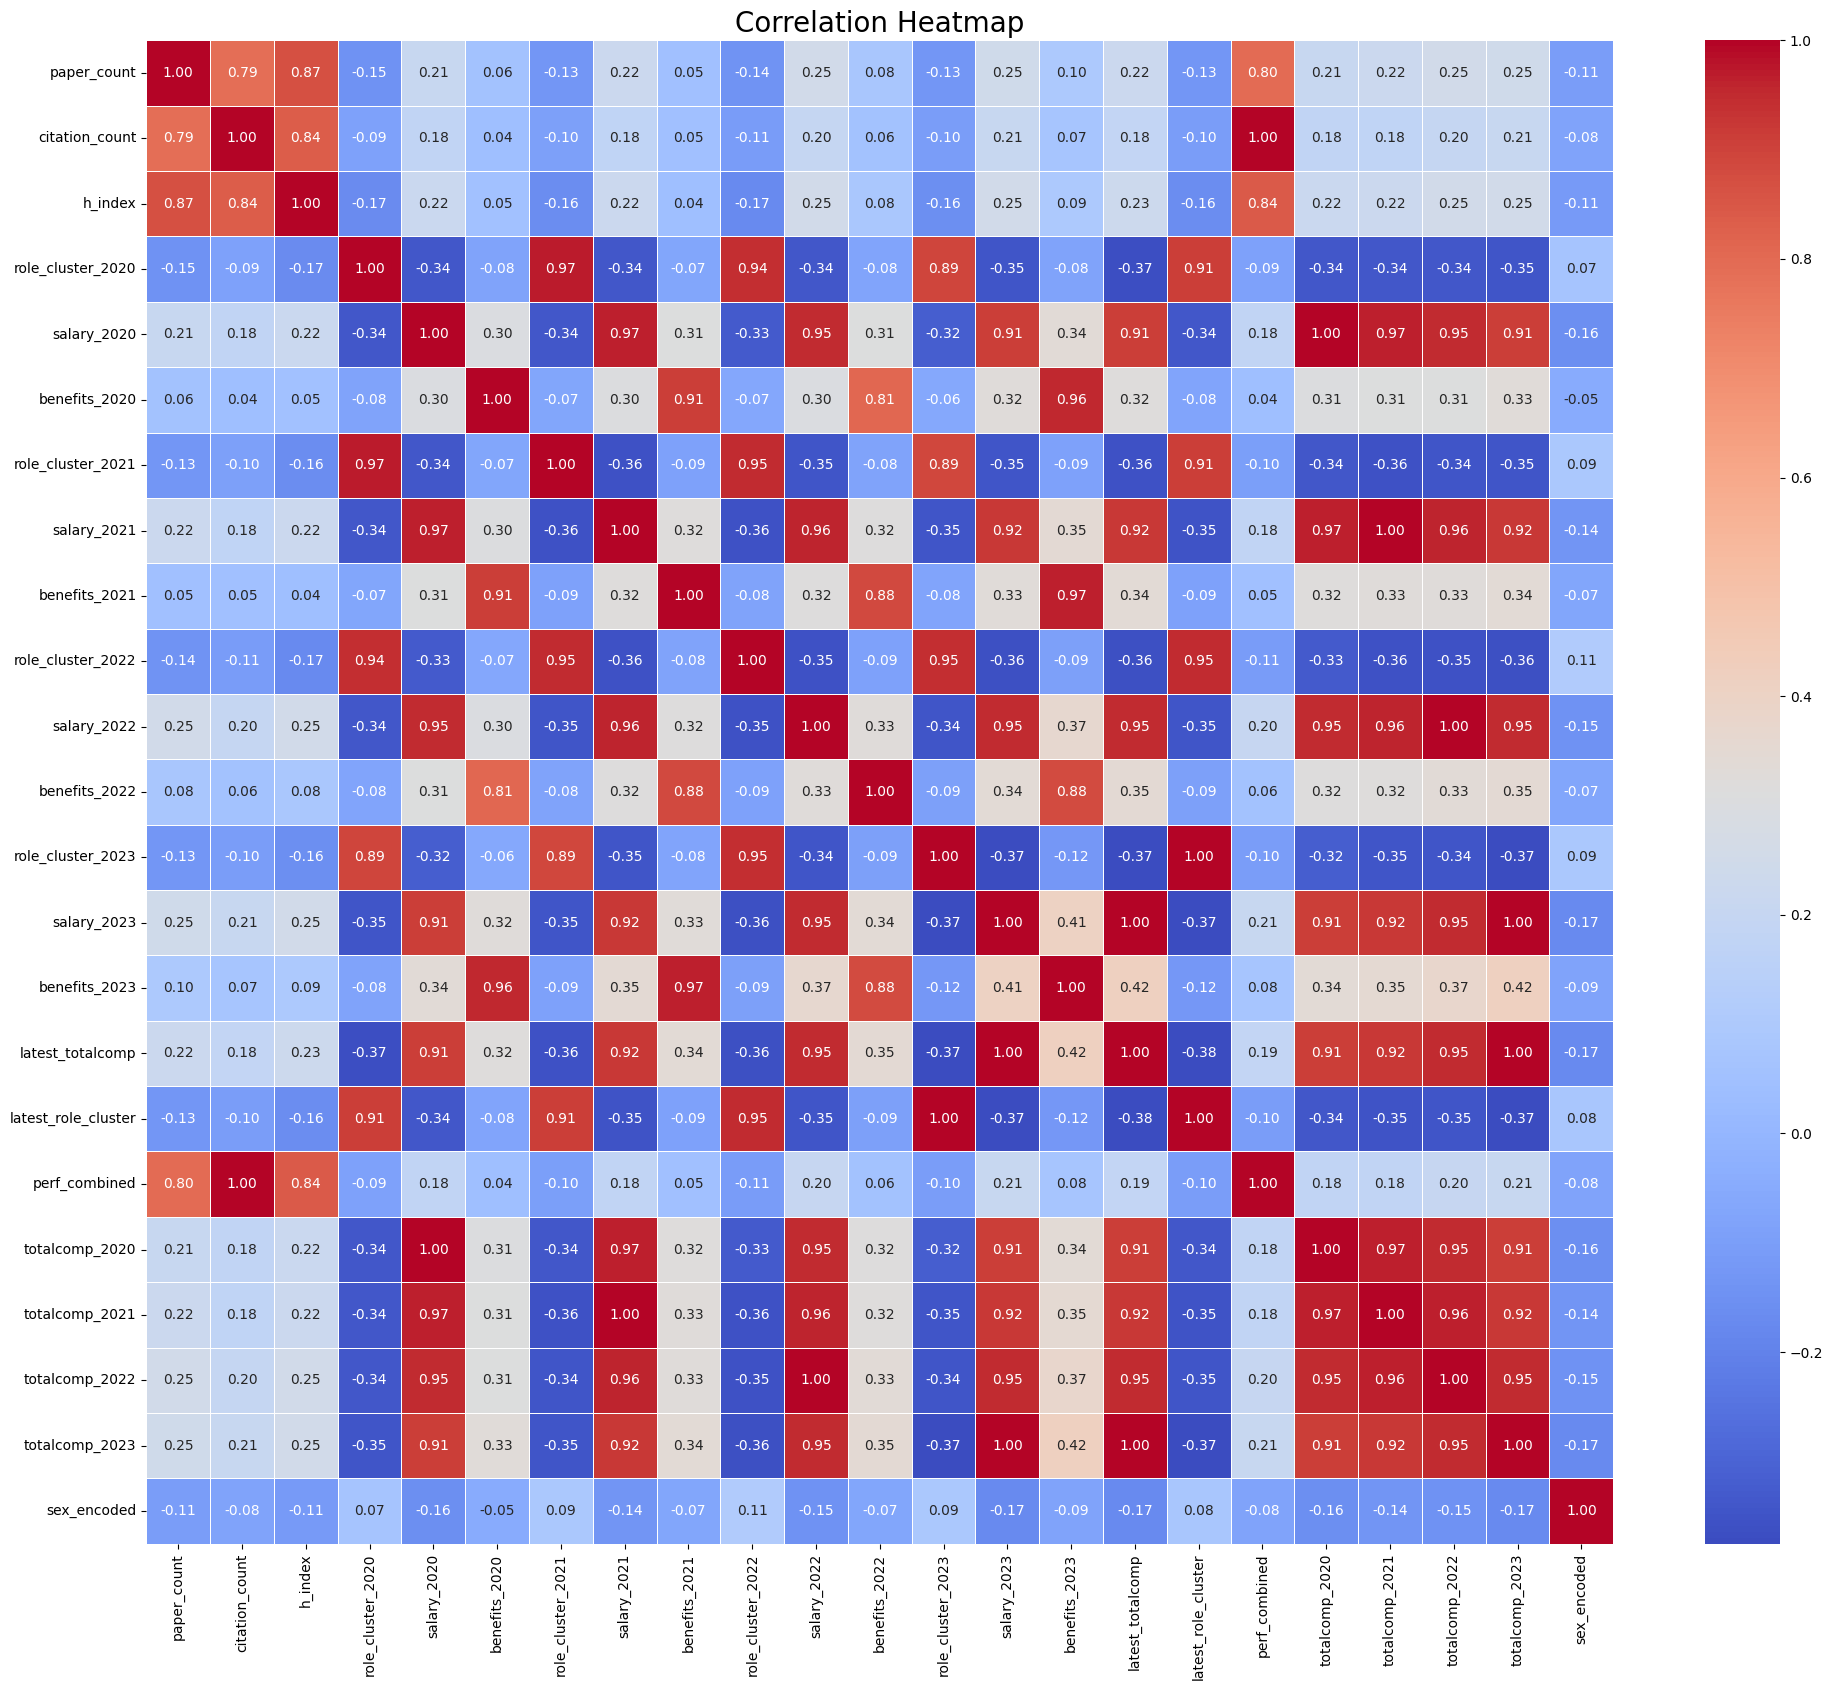

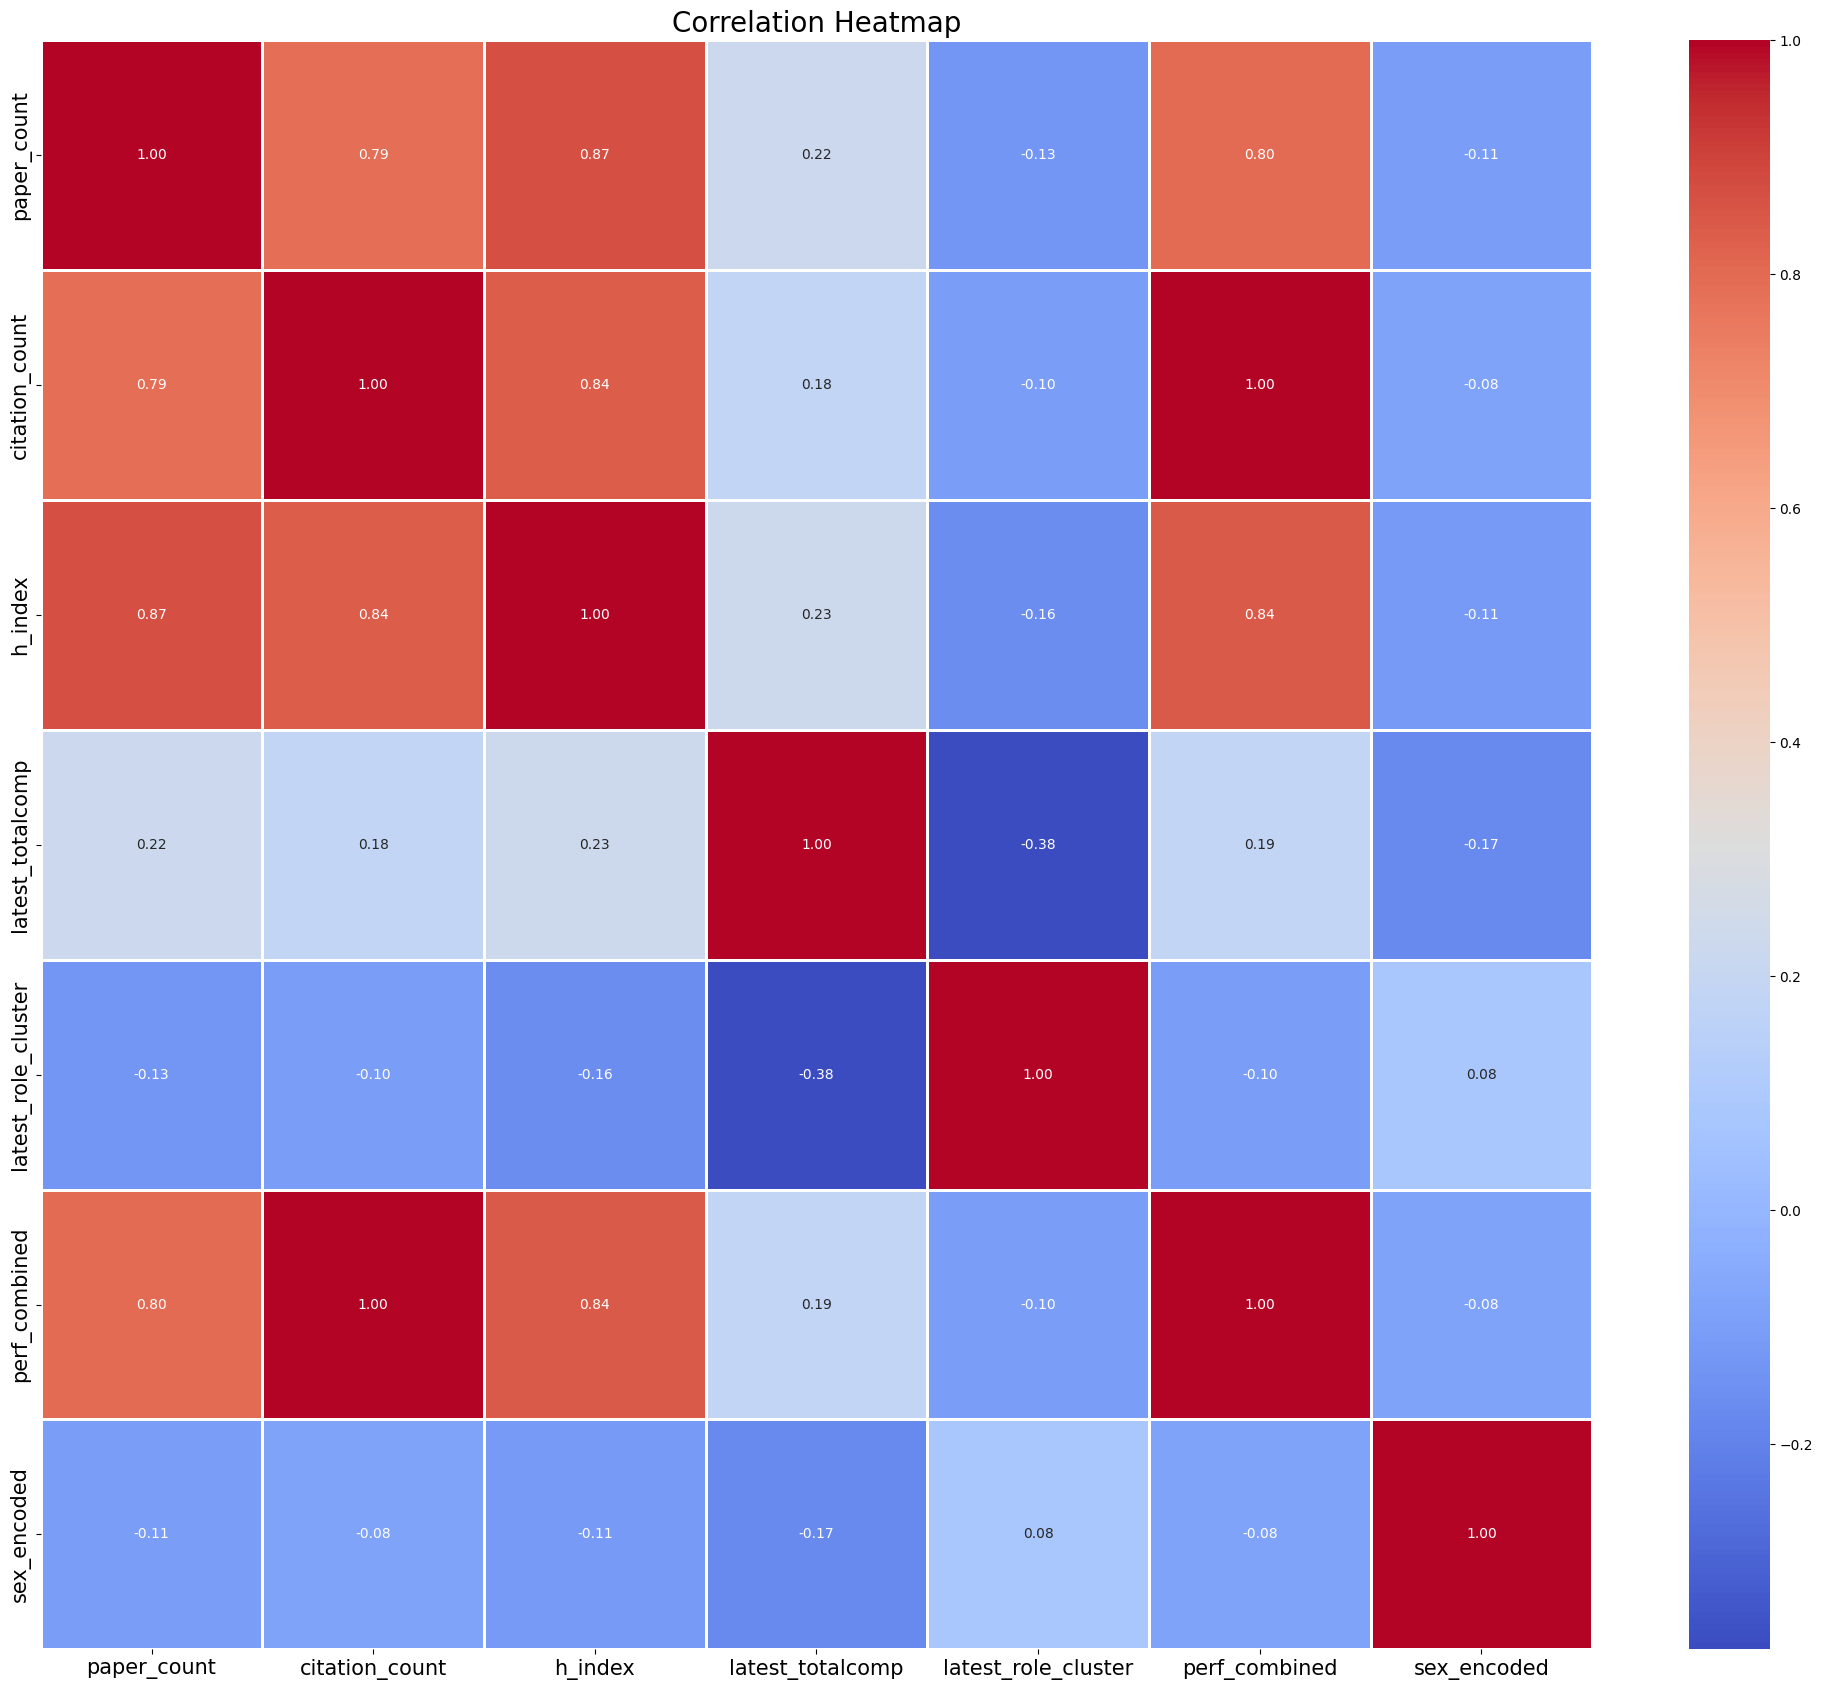

In [106]:
#
# heatmap v1
#

df["sex_encoded"] = df["sex"].map({"M": 1, "F": 2, None: 0})  # encode_sex
numeric_df = df.select_dtypes(include=["float64", "int64"])
numeric_df["sex_encoded"] = df["sex_encoded"]

corr_matrix = numeric_df.corr()

plt.figure(figsize=(20, 17))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap", fontsize=20)
plt.tight_layout()
plt.show()


#
# heatmap v2
#
# conclusion: role and comp correlate, but not role and perf
#

df["sex_encoded"] = df["sex"].map({"M": 1, "F": 2, None: 0})  # encode_sex
numeric_df = df.select_dtypes(include=["float64", "int64"])
numeric_df["sex_encoded"] = df["sex_encoded"]

numeric_df = numeric_df.drop(
    columns=[
        "role_cluster_2020",
        "salary_2020",
        "benefits_2020",
        "role_cluster_2021",
        "salary_2021",
        "benefits_2021",
        "role_cluster_2022",
        "salary_2022",
        "benefits_2022",
        "role_cluster_2023",
        "salary_2023",
        "benefits_2023",
        "totalcomp_2020",
        "totalcomp_2021",
        "totalcomp_2022",
        "totalcomp_2023",
    ]
)
corr_matrix = numeric_df.corr()

plt.figure(figsize=(20, 17))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title("Correlation Heatmap", fontsize=20)
plt.tight_layout()
plt.show()

In [ ]:
# IDEA: demographics
# - male/female ratio
# - male/female ratio per role_cluster

# IDEA: temporal data
# - career progression: change in roles over time, ranking roles
# - trends: visualize num employees, num men/women, salaries, benefits, num papers, citations, h_index, perf_combined - over time
